## Summary 
This code provides a comprehensive analysis of the relationship between oil prices (WTI) and the Weighted Average Cost of Capital (WACC) within energy transition scenarios. It starts by loading historical WTI data and energy scenario data, then processes these datasets by calculating annual WACC values based on maxwacc and minwacc for each scenario. Using a Gradient Boosting Regressor, the code models how WTI prices may influence WACC, evaluating the model's accuracy with R-squared and Mean Squared Error metrics. Additionally, an LSTM model forecasts future WTI prices, enabling long-term projections of WACC. Finally, visualizations illustrate the relationship and trends over time.

## Calculate the average WACC
Based on the data in Calcaterra's et al. (2024) research, it calculates the annual WACC value for each scenario by taking the average of maxwacc and minwacc. Then, assuming each scenario has equal weight, calculate the average WACC for each year across all scenarios.

In [6]:
import pandas as pd
import tempfile

def calculate_and_print_annual_wacc(file_path):
    # Load the CSV file and specify the correct header row (skip the first two rows)
    df = pd.read_csv(file_path, header=2)

    # Select relevant columns: Scenario, Year, maxwacc, minwacc
    df_filtered = df[['Scenario', 'Year', 'maxwacc', 'minwacc']]

    # Convert maxwacc and minwacc columns to numeric, if they are not already numeric
    df_filtered['maxwacc'] = pd.to_numeric(df_filtered['maxwacc'], errors='coerce')
    df_filtered['minwacc'] = pd.to_numeric(df_filtered['minwacc'], errors='coerce')

    # Calculate the average of maxwacc and minwacc
    df_filtered['avgwacc'] = (df_filtered['maxwacc'] + df_filtered['minwacc']) / 2

    # Group by Year and calculate the average WACC for each year
    annual_wacc = df_filtered.groupby('Year')['avgwacc'].mean().reset_index()

    # Print the result to the console
    print("Annual WACC values:")
    print(annual_wacc)

    # Save the result to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".csv") as tmp_file:
        output_file_path = tmp_file.name
        annual_wacc.to_csv(output_file_path, index=False)

    print(f"The file has been saved to: {output_file_path}")
    return output_file_path

# Define the file path for input
file_path = 'Global_Energy_Scenario——Data.csv'

# Call the function
calculate_and_print_annual_wacc(file_path)


Annual WACC values:
    Year   avgwacc
0   2020  0.076768
1   2025  0.073975
2   2030  0.071179
3   2035  0.067843
4   2040  0.064479
5   2045  0.061183
6   2050  0.058008
7   2055  0.057608
8   2060  0.057329
9   2065  0.057088
10  2070  0.056866
11  2075  0.056650
12  2080  0.056446
13  2085  0.056264
14  2090  0.056095
15  2095  0.055940
16  2100  0.055810
The file has been saved to: /var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/tmpue_9lfoi.csv


/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_21750/1537768269.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['maxwacc'] = pd.to_numeric(df_filtered['maxwacc'], errors='coerce')
/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_21750/1537768269.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['minwacc'] = pd.to_numeric(df_filtered['minwacc'], errors='coerce')
/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/ipykernel_21750/1537768269.py:16: SettingWith

'/var/folders/jt/s5bg7p6n4mgfx_dznzr9hr7c0000gn/T/tmpue_9lfoi.csv'

## Predict future WTI spot prices
This code implements a Long Short-Term Memory (LSTM) model to predict future WTI spot prices based on historical data. It loads WTI price data from the dataset(Iania et al., 2024), preprocesses it by selecting relevant columns, handling dates, and normalizing prices. Sequences of normalized data are prepared as input for the LSTM model, which is then trained. After training, the model predicts WTI prices at five-year intervals from 2020 to 2100.

In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset (replace the path with the location of your Excel file)
file_path = 'WTI_price.xlsx'

# Read the 'prices' sheet into a DataFrame
prices_data = pd.read_excel(file_path, sheet_name='prices')

# Clean the data (extract relevant columns)
prices_data_cleaned = prices_data[['Unnamed: 0', 'real WTI spot price']].dropna()
prices_data_cleaned.columns = ['Date', 'Real WTI Spot Price']

# Convert the 'Date' column to datetime format and drop rows with invalid dates
prices_data_cleaned['Date'] = pd.to_datetime(prices_data_cleaned['Date'], errors='coerce')
prices_data_cleaned = prices_data_cleaned.dropna(subset=['Date'])

# Set the 'Date' column as the index
prices_data_cleaned.set_index('Date', inplace=True)

# Manually normalize the 'Real WTI Spot Price' data (min-max normalization)
prices = prices_data_cleaned['Real WTI Spot Price'].values
min_price = np.min(prices)
max_price = np.max(prices)

prices_normalized = (prices - min_price) / (max_price - min_price)

# Define sequence length (e.g., 60 time steps, representing 5 years)
sequence_length = 60
X, y = [], []

# Prepare data sequences and targets for LSTM
for i in range(sequence_length, len(prices_normalized)):
    X.append(prices_normalized[i - sequence_length:i])
    y.append(prices_normalized[i])

X, y = np.array(X), np.array(y)

# Reshape X for LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Manually split the data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

# Predict future values for 2020-2100
future_dates = pd.date_range(start='2020-01-01', end='2105-01-01', freq='5Y')
future_inputs = prices_normalized[-sequence_length:].reshape(1, sequence_length, 1)

future_predictions = []

for date in future_dates:
    # Predict the next value
    next_price = model.predict(future_inputs)
    future_predictions.append(next_price[0, 0])

    # Update the input for the next prediction (append the predicted value)
    future_inputs = np.append(future_inputs[:, 1:, :], next_price.reshape(1, 1, 1), axis=1)

# Inverse transform the predicted future values
future_predictions = np.array(future_predictions) * (max_price - min_price) + min_price

# Create a DataFrame to display the predictions
predicted_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Real WTI Spot Price': future_predictions
})

# Save predictions to CSV file (optional)
predicted_df.to_csv('future_wti_predictions.csv', index=False)

# Display the DataFrame in the notebook
predicted_df  # This will display the table in Jupyter Notebook


Epoch 1/20
19/19 [==============================] - 2s 35ms/step - loss: 0.0286 - val_loss: 0.0175
Epoch 2/20
19/19 [==============================] - 0s 18ms/step - loss: 0.0106 - val_loss: 0.0113
Epoch 3/20
19/19 [==============================] - 0s 18ms/step - loss: 0.0083 - val_loss: 0.0121
Epoch 4/20
19/19 [==============================] - 0s 17ms/step - loss: 0.0074 - val_loss: 0.0089
Epoch 5/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0065 - val_loss: 0.0086
Epoch 6/20
19/19 [==============================] - 0s 18ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 7/20
19/19 [==============================] - 0s 18ms/step - loss: 0.0061 - val_loss: 0.0068
Epoch 8/20
19/19 [==============================] - 0s 17ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 9/20
19/19 [==============================] - 0s 18ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 10/20
19/19 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 11/

,Date,Predicted Real WTI Spot Price
0,2020-12-31,24.794350
1,2025-12-31,24.869862
2,2030-12-31,24.964516
3,2035-12-31,25.077778
4,2040-12-31,25.205524
5,2045-12-31,25.342220
6,2050-12-31,25.482006
7,2055-12-31,25.619530
8,2060-12-31,25.750336
9,2065-12-31,25.871155


## Predict the average Weighted Average Cost of Capital (WACC) based on predicted WTI prices
This code builds and evaluates a Gradient Boosting model to predict the average Weighted Average Cost of Capital (WACC) based on predicted WTI prices. It loads WTI predictions and global scenario data, calculates the average WACC for each year, and merges the data. After splitting the data into training and testing sets, the model is trained to predict WACC. 

In [8]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Load the data files
wti_path = 'future_wti_predictions.csv'
scenario_path = 'Global_Energy_Scenario——Data.csv'

# Load WTI predictions data and extract the year
wti_df = pd.read_csv(wti_path)
wti_df['Year'] = pd.to_datetime(wti_df['Date']).dt.year
wti_df = wti_df.rename(columns={'Predicted Real WTI Spot Price': 'WTI_Price'})

# Load Global Energy Scenario data and calculate the average WACC
scenario_df = pd.read_csv(scenario_path, header=2)
scenario_df['avgwacc'] = (scenario_df['maxwacc'] + scenario_df['minwacc']) / 2

# Merge WTI predictions with the average WACC values on 'Year'
merged_df = pd.merge(wti_df[['Year', 'WTI_Price']], scenario_df[['Year', 'avgwacc']], on='Year', how='inner')

# Define features (WTI_Price) and target (avgwacc)
X = merged_df[['WTI_Price']]
y = merged_df['avgwacc']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the results
print("Gradient Boosting Model Results:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Optional: Display feature importance for interpretability
feature_importances = gb_model.feature_importances_
print("Feature Importances:", feature_importances)


Gradient Boosting Model Results:
R-squared: 0.1977
Mean Squared Error: 0.0002
Feature Importances: [1.]


## Trends of WACC and WTI prices over time
The left y-axis shows WACC, with a red line and a range of 0 to 0.1. The right y-axis displays WTI prices, represented by a blue line with a range limited to 23.8 to 24.6. The plot includes gridlines, labeled axes, and legends on both sides for clarity, making it easy to compare changes in WACC and WTI prices within specified ranges.

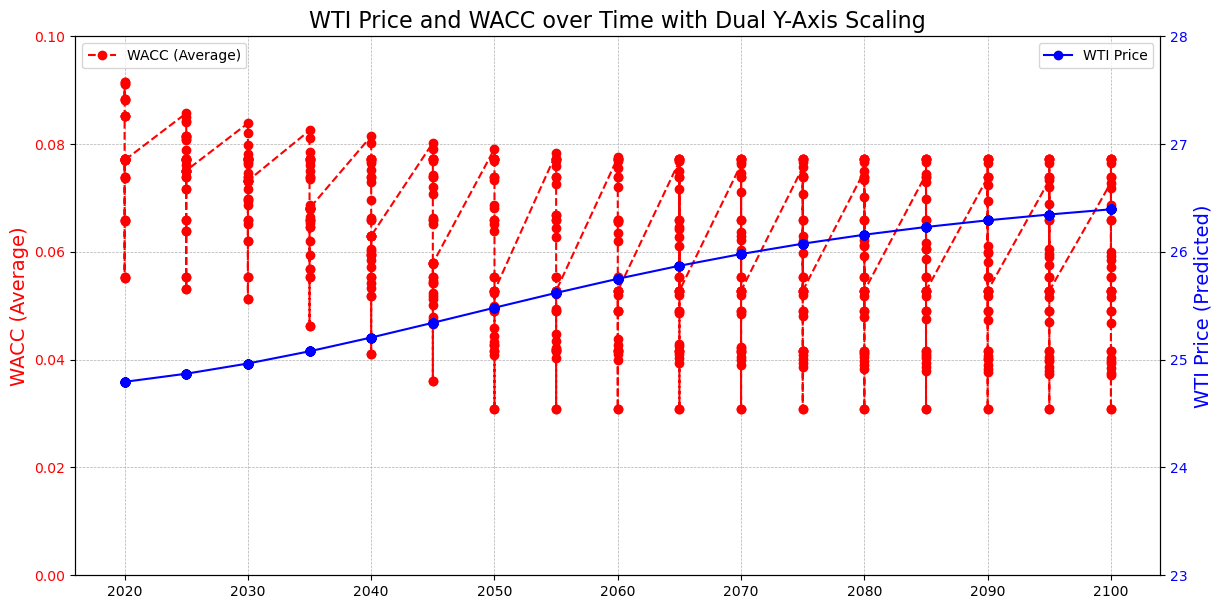

In [11]:
import matplotlib.pyplot as plt

# Create a figure and axis with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot WACC on the left y-axis (scaled from 0 to 0.1)
ax1.plot(merged_df['Year'], merged_df['avgwacc'], marker='o', linestyle='--', color='red', label="WACC (Average)")
ax1.set_ylim(0, 0.1)
ax1.set_ylabel("WACC (Average)", fontsize=14, color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a second y-axis for WTI_Price with a limited range of 23-25
ax2 = ax1.twinx()
ax2.plot(merged_df['Year'], merged_df['WTI_Price'], marker='o', linestyle='-', color='blue', label="WTI Price")
ax2.set_ylim(23, 28)  # Set y-axis range to 23-25 for WTI_Price
ax2.set_ylabel("WTI Price (Predicted)", fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Set x-axis label and title
plt.title("WTI Price and WACC over Time with Dual Y-Axis Scaling", fontsize=16)
plt.xlabel("Year", fontsize=14)

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()


 ## Relationship between predicted WTI prices and WACC。
 This code visualizes the relationship between predicted WTI prices and WACC from two data sources: annual WACC data and global energy scenario data. After loading and processing these datasets, it merges them based on the year. The plot displays scatter points for WTI vs. annual WACC (in red) and WTI vs. scenario WACC (in blue). A linear regression line with a confidence interval is added for the annual WACC data. Each data point is annotated with its year, enhancing readability of time trends.

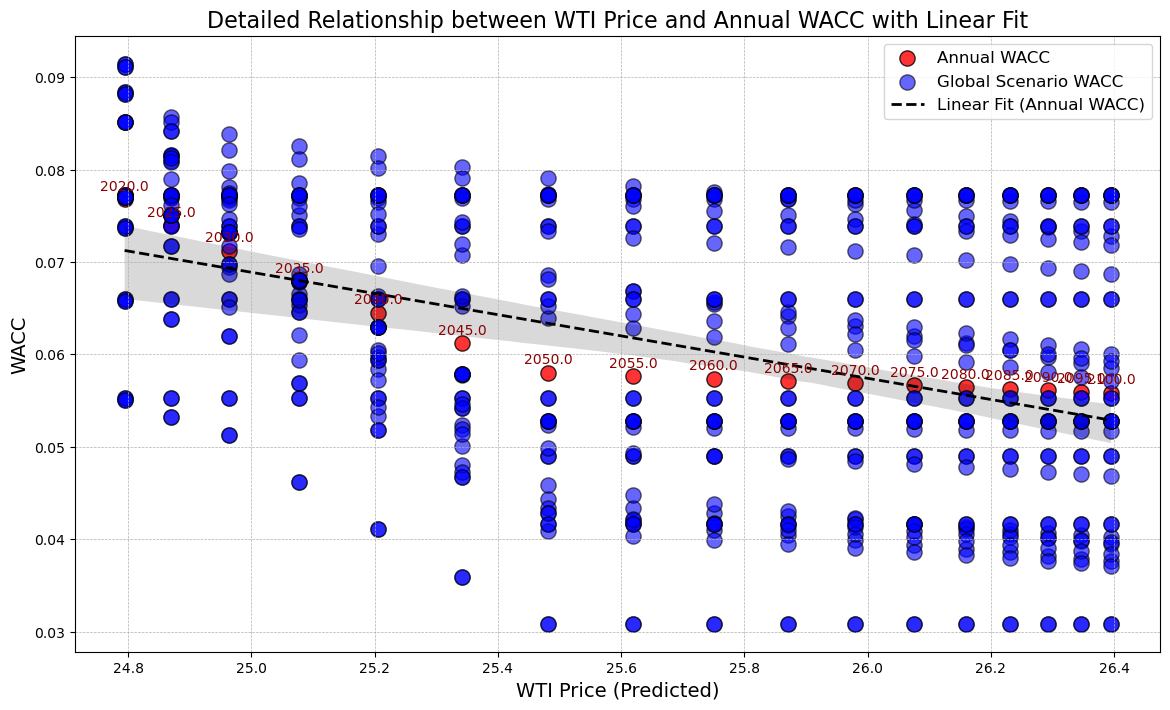

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths for the future WTI predictions, annual WACC, and global energy scenario data
wti_path = 'future_wti_predictions.csv'
annual_wacc_path = 'annual_wacc.csv'
global_energy_scenario_path = 'Global_Energy_Scenario——Data.csv'

# Load the datasets
wti_df = pd.read_csv(wti_path)
annual_wacc_df = pd.read_csv(annual_wacc_path, skiprows=1)  # Skip the first line for correct parsing
global_scenario_df = pd.read_csv(global_energy_scenario_path, header=2)

# Extract the year from the WTI predictions and rename for consistency
wti_df['Year'] = pd.to_datetime(wti_df['Date']).dt.year
wti_df = wti_df.rename(columns={'Predicted Real WTI Spot Price': 'WTI_Price'})

# Prepare the annual WACC data by renaming the columns
annual_wacc_df = annual_wacc_df.rename(columns={'Year': 'Year', 'avgwacc': 'WACC'})

# Calculate average WACC from maxwacc and minwacc in the global energy scenario data
global_scenario_df['avgwacc'] = (global_scenario_df['maxwacc'] + global_scenario_df['minwacc']) / 2

# Merge WTI data with annual WACC and global scenario WACC data on 'Year'
merged_annual = pd.merge(wti_df[['Year', 'WTI_Price']], annual_wacc_df, on='Year', how='inner')
merged_scenario = pd.merge(wti_df[['Year', 'WTI_Price']], global_scenario_df[['Year', 'avgwacc']], on='Year', how='inner')

# Plotting WTI vs WACC from both annual WACC and global energy scenario with a detailed linear regression line for annual WACC
plt.figure(figsize=(14, 8))

# Scatter plot for annual WACC data points in red with larger markers
plt.scatter(merged_annual['WTI_Price'], merged_annual['WACC'], color='red', label='Annual WACC', s=120, alpha=0.8, edgecolor='black')

# Scatter plot for global scenario WACC data points in blue with larger markers
plt.scatter(merged_scenario['WTI_Price'], merged_scenario['avgwacc'], color='blue', label='Global Scenario WACC', s=120, alpha=0.6, edgecolor='black')

# Fit and plot a linear regression line using Seaborn for WTI vs Annual WACC, with confidence interval
sns.regplot(x='WTI_Price', y='WACC', data=merged_annual, scatter=False, color="black", line_kws={"linestyle": "--", "linewidth": 2}, label="Linear Fit (Annual WACC)")

# Annotate each point with the year
for i, row in merged_annual.iterrows():
    plt.text(row['WTI_Price'], row['WACC'] + 0.001, f"{row['Year']}", 
             horizontalalignment='center', size='medium', color='darkred')

# Set titles and labels with larger font for readability
plt.title("Detailed Relationship between WTI Price and Annual WACC with Linear Fit", fontsize=16)
plt.xlabel("WTI Price (Predicted)", fontsize=14)
plt.ylabel("WACC", fontsize=14)

# Customize legend and grid
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()
